In [6]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [7]:
# pcap to dataframe

pcap = rdpcap("../pcaps/webinar_pcap_compressed_3.pcap")

ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    field_values = []
    for field in ip_fields:
        if field == 'options':
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# replace proto values with strings 'tcp' or 'udp'

#df['proto'] = df['proto'].replace([6],'tcp')
#df['proto'] = df['proto'].replace([17],'udp')

df = df.reset_index()
df["len"] = pd.to_numeric(df["len"])
df["time"] = pd.to_numeric(df["len"])

df = df.drop(columns="index")

proto
6     43
17     7
Name: src, dtype: int64


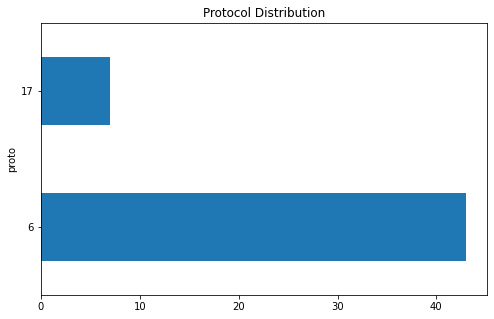

In [8]:
protocol_stats = df.groupby("proto")['src'].count()
print(protocol_stats)
protocol_stats.plot(kind='barh',title="Protocol Distribution",figsize=(8,5))
plt.show()




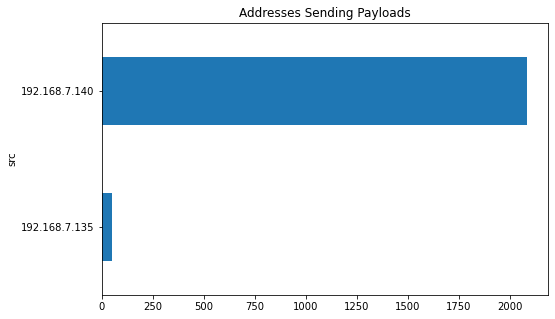

In [9]:
# Graph - Group by Source Address and Payload Sum

source_addresses = df.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))
plt.show()


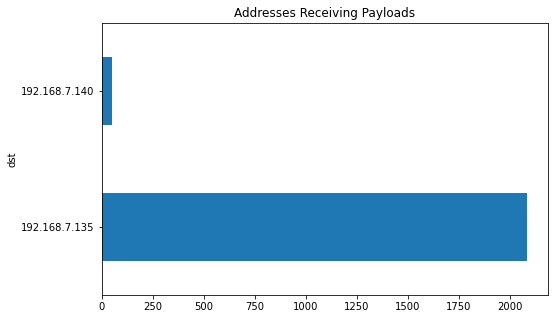

In [10]:
# Graph - Group by Dest Address and Payload Sum

dst_addresses = df.groupby("dst")['payload'].sum()
dst_addresses.plot(kind='barh',title="Addresses Receiving Payloads",figsize=(8,5))
plt.show()


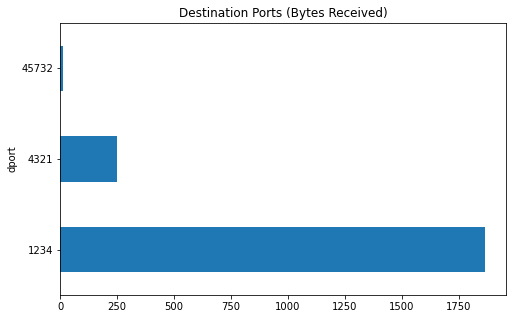

In [11]:
# Graph - Group by Destination Port and Payload Sum

destination_ports = df.groupby("dport")['payload'].sum()
destination_ports.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))
plt.show()


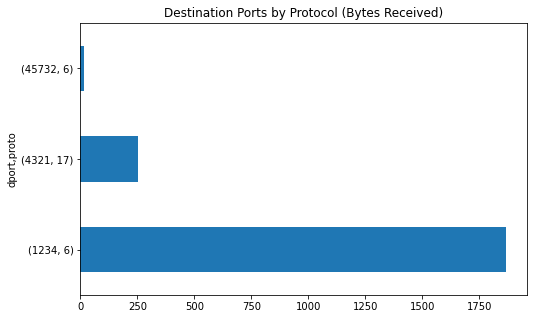

In [12]:
# Graph - Group by Destination Port, Protocol and Payload Sum

destination_payloads_proto = df.groupby(["dport","proto"])['payload'].sum()
destination_payloads_proto.plot(kind='barh',title="Destination Ports by Protocol (Bytes Received)",figsize=(8,5))
plt.show()


In [13]:

# Adding human-readable timestamp column

def return_timestamp(x):
    return datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f')

df['timestamp'] = df['time'].apply(lambda x: (return_timestamp(x)))
df['timestamp'] = pd.to_datetime(df['timestamp'])



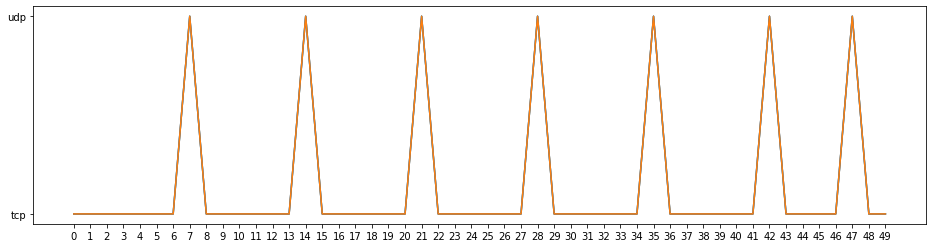

In [14]:
df['proto'].plot(figsize=(16,4))
df['proto'].plot(subplots=True, figsize=(16,4))
df['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

# Notice the heartbeat packet

In [15]:
# Visualization across 3 pcaps - helps to see what the fields are


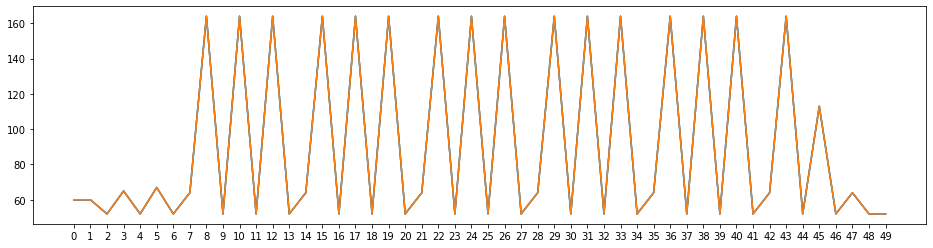

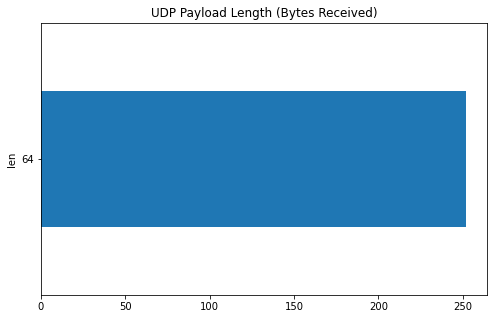

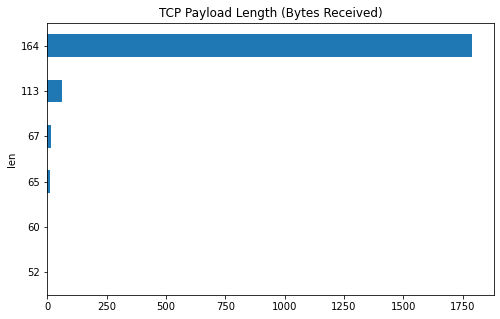

In [16]:
# Packet length 

df['len'].plot(figsize=(16,4))
df['len'].plot(subplots=True, figsize=(16,4))
df['len'].plot(y=['len'], figsize=(16,4))
plt.xticks(df.index)
plt.show()

# UDP length 

udp_df = df[df['proto'] == 17]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="UDP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP length

udp_df = df[df['proto'] == 6]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="TCP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()


# TCP segment size 

# TCP segment size by IP address

version        object
ihl            object
tos            object
len             int64
id             object
flags          object
frag           object
ttl            object
proto          object
chksum         object
src            object
dst            object
options        object
time           object
sport          object
dport          object
seq            object
ack            object
dataofs        object
reserved       object
flags          object
window         object
chksum         object
urgptr         object
options        object
payload        object
payload_raw    object
payload_hex    object
timestamp      object
dtype: object

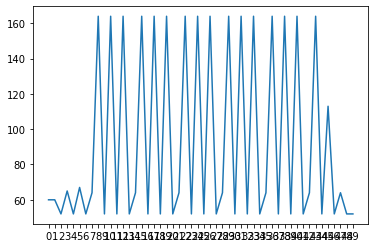

In [20]:
# Search IP in payload - visualization

df['len'].plot()
plt.xticks(df.index)
df.dtypes


In [18]:
# Geocoordinates from several pcaps - payload
